<a href="https://colab.research.google.com/github/evgeny-kolonsky/Lab3_Coupled_Oscillator/blob/phase_response/Lab3_Oscillator_Experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab3 oscillator

Evgeny Kolonsky, Nov 2023

# One degree of freedom

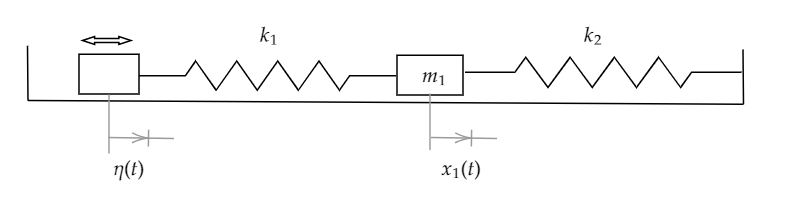

https://www.mathcha.io/editor/X5ek2C9yiX3fDpCp6nBwlUVnkOePf1QlmVnimELJWe

Equation
$$
m_1 \ddot x_1 + b_1 \dot x_1 + (k_1 + k_{2}) x_1 = \eta_0 \cos\omega t
$$
Steady state solution
$$
x(t) = C \cos \omega t
$$


In [20]:
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
import requests
from scipy.signal import find_peaks, peak_prominences
from scipy.stats import linregress

In [21]:
def get_signal(url, show=False):
  data = np.loadtxt(url).T
  t = data[1, :]
  # convert from counts to meters
  x = data[2:, :] /counts * length
  # how many signals: Kruze may return  from 1 up to 4
  signals = x.shape[0]
  # shift mean to zero
  for i in range(signals):
    x[i] -= x[i].mean()
  if show:
    for i in range(signals):
      plt.plot(t, x[i], label=f'Cart {i+1}')
    plt.grid()
    plt.xlabel('Time, s')
    plt.ylabel('Amplitude, m')
    plt.legend()
  # returns t and signals x1, x2, ..
  answer = [t] + [x[i] for i in range(signals)]
  return tuple(answer)

def get_peaks(t, signal, show=False):
  rate = np.median(np.diff(t))
  min_period = 0.2 #s
  min_prominence = 2e-3 ## 2 mm
  peaks, _ = find_peaks(signal, prominence=min_prominence,
                        distance=min_period/rate )
  if show:
    plt.plot(signal)
    plt.grid()
    plt.plot(peaks, signal[peaks], "x")
    plt.xlabel('Points')
    plt.ylabel('Signal')
  return t[peaks], signal[peaks]

def get_frequency(t, harmonic_signal):
  tpeaks, _ = get_peaks(t, harmonic_signal)
  periods = np.diff(tpeaks)
  f0 = 1 / periods
  return np.mean(f0), np.std(f0)

# get cosine of phase difference
# between two harmonic signals
# having the same frequency
def get_cosine(signal1, signal2):
  s11 = signal1 @ signal1
  s12 = signal1 @ signal2
  s22 = signal2 @ signal2
  cosine = s12 / np.sqrt(s11 * s22)
  return cosine

def get_quality(t, harmonic_signal, show=False):
  tpeaks, peaks = get_peaks(t, harmonic_signal)
  decay = np.log(peaks / peaks[0])
  cycles = range(len(peaks))
  fit = linregress(cycles, decay)
  quality = -np.pi/fit.slope
  N = quality / np.pi
  if show:
    plt.plot(cycles, decay, 'o', label='Measurements')
    plt.plot(cycles, fit.slope*cycles + fit.intercept, label=fr'Fit $Q=\pi*N$: {quality:.1f}')
    plt.xlabel(rf'$N$ = {N:.1f} cycles for $1/e$ decay')
    plt.ylabel('Log amplitude decay')

    ytix = np.unique(decay).astype(int)
    xtix = np.unique(ytix / fit.slope).astype(int)
    plt.yticks(ytix)
    plt.xticks(xtix)

    plt.grid()
    plt.legend()
  return quality

### Direct measurements

In [22]:
# Springs
l = 97.95e-3 # m, spring strain
g = 9.8 # m/s^2

# left spring (adjacent to driver)
weight1 = 44.8e-3 #
k1 = weight1 * g /l
mk1 = 17e-3 # kg

# right spring
weight2 = 44.8e-3 #
k2 = weight2 * g /l
mk2 = 17e-3 # kg

# Carts
m1 = 208.9e-3 #kg

#Effective mass
m1_eff = m1 + (mk1 + mk2)/2
k_eff = k1 + k2

counts = 236
length = 123e-3

omega0 = np.sqrt(k_eff / m1_eff)
pi2 = 2 * np.pi
freq_theor = omega0 /pi2

# Quality factors (found by observation of free dumped oscillations)
Q1 = 24
b1 = np.sqrt(k_eff * m1_eff) / Q1

print(f'Estimated natural frequency {freq_theor:.1f} Hz')
print(f'Corresponding period {1/freq_theor:.3f} s')

Estimated natural frequency 1.0 Hz
Corresponding period 0.997 s


### Free dumped oscillations observed

In [23]:
url='https://raw.githubusercontent.com/evgeny-kolonsky/Lab3_Coupled_Oscillator/main/2611/free_4.txt'
t, x = get_signal(url, show=False)
get_quality(t, x, show=False)

24.044763439532197

### Apmlitude response model

Looking for solution
$$ x_1(t) = C e^{i\omega t}$$
where $C$ is complex number.

$$
C e^{i \omega t} (-m_1 \omega^2   + i b_1 \omega +  k_1 + k_{2} ) = \eta_0 k_1  e^{i \omega t}
$$
Therefore amplitude relative response
$$
\frac{C}{\eta_0} = \frac{k_1}{-m_1 \omega^2   +  k_1 +k_{2} + i b_1 \omega}
$$

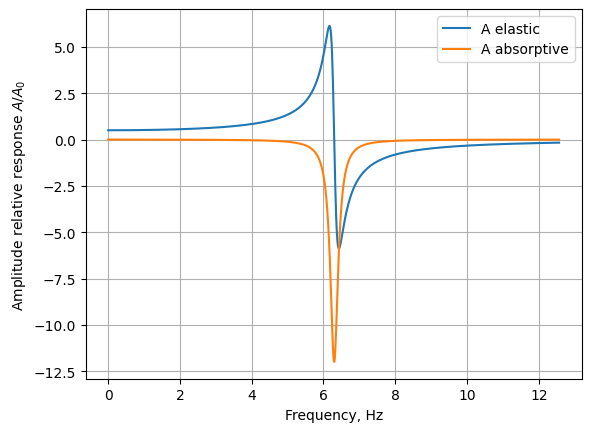

In [24]:
def C(omega, K, M, B, F):
  amp = F / (K - M* omega**2 + 1.j * omega * B)
  return amp

omega = np.linspace(0.,2, 1000) *pi2
amp = C(omega, k_eff, m1_eff, b1, k1)
#plt.plot(omega, np.abs(amp), label='abs(A)')
plt.plot(omega, np.real(amp), label='A elastic')
plt.plot(omega, np.imag(amp), label='A absorptive')
plt.xlabel('Frequency, Hz');
plt.ylabel('Amplitude relative response $A/A_0$')
plt.grid()
plt.legend()



### Amplitude repsonse experiment points

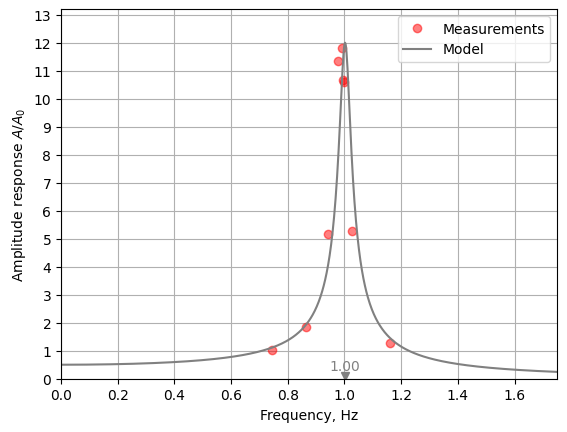

In [25]:
names = [400, 460, 480, 500, 508, 510, 512, 530, 590]
fw = np.array([])
c = np.array([])
for name in names:
  url = f'https://raw.githubusercontent.com/evgeny-kolonsky/Lab3_Coupled_Oscillator/main/2611/r_{name}.txt'
  t, x1, x2 = get_signal(url, show=False)
  # get driver frequency
  fw = np.append(fw, get_frequency(t, x1)[0])
  # get driver amplitude
  _, amps = get_peaks(t, x1)
  eta = np.mean(amps)
  # get mass1 amplitude
  _, amps = get_peaks(t, x2)
  c = np.append(c, np.mean(amps)/eta)

  #print(f'{name}, {fw[-1]:.2f} Hz, {c[-1]:.1f}')

idx = np.argsort(fw) # sorting
plt.plot(fw[idx], c[idx],  alpha=0.5, linestyle=' ', marker='o', c='red', label='Measurements')


#for ind in idx:
#  plt.annotate(names[ind], xy=(fw[ind], c[ind]), color='gray')
plt.grid()
plt.xlabel('Frequency, Hz')
plt.ylabel(f'Amplitude response $A/A_0$')

# theory
freqs =np.linspace(0.,1.75, 1000)
c = np.abs(C(freqs*pi2, k_eff, m1_eff, b1, k1))
plt.plot(freqs, c,  c='gray', label='Model')

plt.plot(freq_theor, 0.1, color='gray', marker="v")
plt.annotate(f'{freq_theor:.2f}', xy=(freq_theor, 0.3),  color='gray', ha='center')

plt.legend()
plt.ylim(0, np.max(c)*1.1)
plt.yticks(np.arange(0, np.max(c)*1.1))
plt.xlim(0, 1.75 )

plt.legend();


# Two degrees of freedom

Amplitude response as a function of driving displacemet

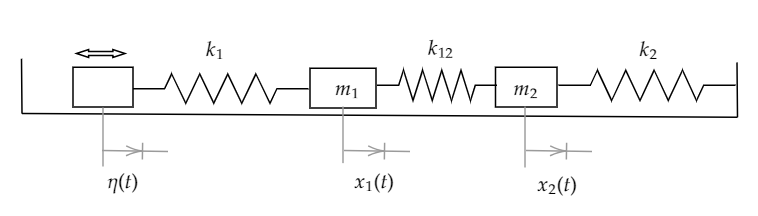

https://www.mathcha.io/editor/X5ek2C9yiX3fDpCp6nBwlUVnkOePf1QlmVnimELJWe

$$
\begin{matrix}
  m_1 \ddot x_1  =& -k_1(x_1 - \eta) + k_{12}(x_2 - x_1) - b_1 \dot x_1\\
  m_2 \ddot x_2  =& -k_{12}(x_2 - x_1) + k_2 x_2 - b_2 \dot x_2
\end{matrix}
$$

## Direct measurements

In [26]:
# Springs
l = 97.95e-3 # m, spring strain
g = 9.8 # m/s^2

# left spring (attached to cart B)
weight1 = 44.8e-3 #
k1 = weight1 * g /l
mk1 = 17e-3 # kg

# right spring (attached to cart C)
weight2 = 44.8e-3 #
k2 = weight2 * g /l
mk2 = 17e-3 # kg

# middle spring (between carts C and B)
weight12 = 44.8e-3 #
k12 = weight12 * g /l
mk12 = 17e-3 # kg

# Carts (6A, 6B, 6C)
m1 = 208.9e-3 #kg
m2 = 213.8e-3
counts = 236
length = 123e-3

# Effective masses
m1_eff = m1 + mk1/2 + mk12/2
m2_eff = m2 + mk2/2 + mk12/2

# Quality factors (found by observation of free dumped oscillations)
Q1 = 26.6
Q2 = 25.0
b1 = np.sqrt((k1 + k12) * m1_eff) / Q1
b2 = np.sqrt((k2 + k12) * m2_eff) / Q2

In [27]:
url='https://raw.githubusercontent.com/evgeny-kolonsky/Lab3_Coupled_Oscillator/main/2611/2/free_C.txt'
t, _, x = get_signal(url)
print(get_quality(t, x))

25.024925440579153


In [28]:
url='https://raw.githubusercontent.com/evgeny-kolonsky/Lab3_Coupled_Oscillator/main/2611/2/free_b.txt'
t, x = get_signal(url)
print(get_quality(t, x))

26.624261533806568


## Expected natural frequencies and response

Masses matrix
$$
M =  \begin{bmatrix} m_1 & 0 \\ 0 & m_2 \end{bmatrix} ,
$$
Elastic coefficients matrix
$$
K = \begin{bmatrix} k_1 +k_{12} & -k_{12} \\ -k_{12} & k_{12} +k_2 \end{bmatrix},
$$
Equation for free oscillations without friction
$$
M \ddot X(t) + K X(t) = 0
$$

Let $I$ - diagonal identity matrix. Then egenvector $\lambda$  is found from equation
$$
\det |M^{-1} K - \lambda I| =
\begin{vmatrix}
        \frac{k_1 +k_{12}}{m_1} - \lambda & -\frac{k_{12}}{m_1} \\
        -\frac{k_{12}}{m_2} & \frac{k_{12} +k_2}{m_2} - \lambda
        \end{vmatrix}
        = 0
$$


In [29]:
M = np.array([[m1_eff, 0],
              [0, m2_eff]])
K = np.array([[k1 + k12, -k12],
              [-k12, k12 + k2]])

B = np.array([[b1, 0],
              [0, b2]])

F = np.array([
              [k1],
              [0]
              ])  # force applied only to 1st mass

eigenvalues, E = LA.eig(LA.inv(M) @ K)
omega_theor = np.sqrt(eigenvalues)
freqs_theor = omega_theor/pi2 # Herz
print(f'Estimated natural frequencies {freqs_theor[0]:.1f} Hz, {freqs_theor[1]:.1f} Hz')
print(f'Corresponding periods         {1/freqs_theor[0]:.2f} s, {1/freqs_theor[1]:.2f} s')


Estimated natural frequencies 1.2 Hz, 0.7 Hz
Corresponding periods         0.82 s, 1.42 s


## Expected amplitude response

Friction matrix
$$
B =  \begin{bmatrix} b_1 & 0 \\ 0 & b_2 \end{bmatrix} ,
$$
Force amplitude vector
$$
F =  \eta_0 \begin{bmatrix} k_1 \\ 0 \end{bmatrix} ,
$$
Equation for forced oscillations with friction
$$
M \ddot X(t) + B\dot X(t) + K X(t) = F e^{i \omega t}
$$
Steady-state solution
$$
X(t) = C e^{i \omega t},
$$
where $C$ is vector of complex amplitudes.

Substitute steady-state solution to motion equation to find $C$:
$$
(-\omega^2 M + i \omega B + K) \times C = F
$$
Let
$$
Z =  -\omega^2 M + i \omega B + K.
$$

Therefore  amplitudes relative response
$$
\frac{C}{\eta_0} =  Z^{-1} \frac{F}{\eta_0}
$$


In [30]:
def complex2real(amplitude, with_sign=True):
  a = np.abs(amplitude)
  if with_sign:
    a *= np.sign(np.real(amplitude))
  return a

def C(omega, K, M, B, F):
  Z = K - M * omega**2 + 1.j *omega * B
  zinv = LA.inv(Z)
  c = zinv @ F

  # first amplitude complex
  c1 = c[0][0]
  c1r = complex2real(c1)
  # second amplitude complex
  c2 = c[1][0]
  c2r = complex2real(c2)
  return c1, c2

### Non-zero friction case

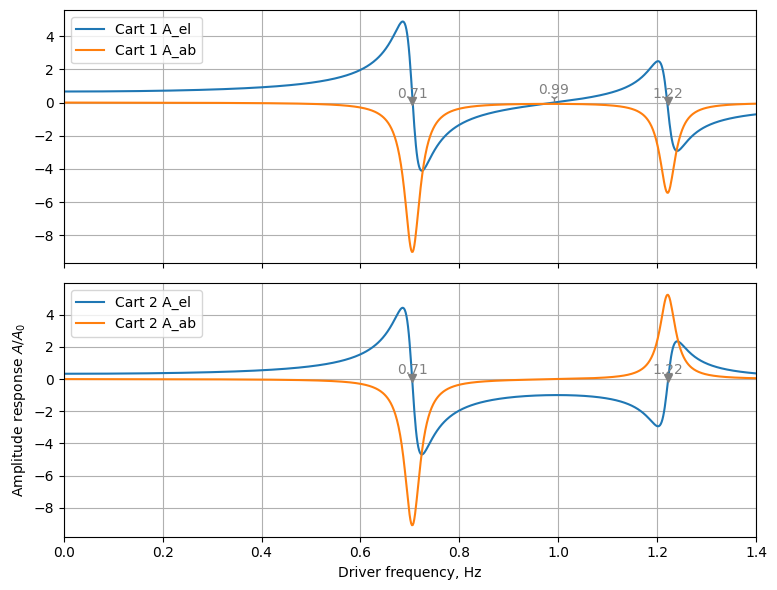

In [31]:
# Amplitudes
omegas = np.linspace(0,10, 1000)

c = np.array([C(omega, K, M, B, F) for omega in omegas]).T


fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 6), sharex=True)
for i in [0,1]:
  axes[i].plot(omegas/pi2, np.real(c[i]),  label=f'Cart {i+1} A_el')
  axes[i].plot(omegas/pi2, np.imag(c[i]),  label=f'Cart {i+1} A_ab')
  axes[i].grid()
  axes[i].legend()
  # mark natural freqs
  for nat in omega_theor/pi2:
    axes[i].plot(nat, 0.1, color='gray', marker="v")
    axes[i].annotate(f'{nat:.2f}', xy=(nat, 0.3),  color='gray', ha='center')

# still point at cart 1 plot
antiresonance = omegas[np.argmin(np.abs(c[0]))] / pi2
axes[0].plot(antiresonance, 0.3, color='gray', marker="1")
axes[0].annotate(f'{antiresonance:.2f}', xy=(antiresonance, 0.5),  color='gray', ha='center')

plt.xlabel(r'Driver frequency, Hz')
plt.xlim(0, 1.4)
plt.ylabel('Amplitude response $A/A_0$');
fig.tight_layout()


## Amplitude response experiment points

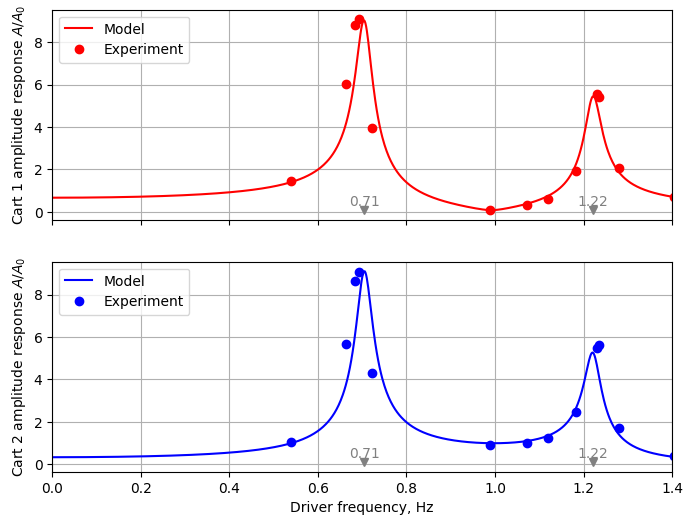

In [32]:
names = [300, 360, 370, 380, 390, 510, 550, 570, 600,  618, 620, 640, 700]
fw = np.array([])
c1 = np.array([])
c2 = np.array([])

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 6), sharex=True)

colors = ['red', 'blue']
# Model plot
for i in [0,1]:
  axes[i].plot(omegas/pi2, np.abs(c[i]),  c=colors[i], label=f'Model')
  # mark natural freqs
  for nat in omega_theor/pi2:
    axes[i].plot(nat, 0.1, color='gray', marker="v")
    axes[i].annotate(f'{nat:.2f}', xy=(nat, 0.3),  color='gray', ha='center')

# Experiment points
for name in names:
  url = f'https://raw.githubusercontent.com/evgeny-kolonsky/Lab3_Coupled_Oscillator/main/2611/2/r2_{name}.txt'
  t, xdriver, x1, x2 = get_signal(url, show=False)
  # get driver frequency
  fw = np.append(fw, get_frequency(t, xdriver)[0])
  # get driver amplitude
  _, amps = get_peaks(t, xdriver)
  eta = np.mean(amps)
  # get mass1 amplitude
  _, amps = get_peaks(t, x1)
  c1 = np.append(c1, np.mean(amps)/eta)
  # get mass2 amplitude
  _, amps = get_peaks(t, x2)
  c2 = np.append(c2, np.mean(amps)/eta)

axes[0].plot(fw, c1, 'o', c=colors[0], label='Experiment')
axes[1].plot(fw, c2, 'o', c=colors[1], label='Experiment')

# common settings
for i in [0,1]:
  axes[i].grid()
  axes[i].legend(loc='upper left')
  axes[i].set_ylabel(f'Cart {i+1} amplitude response $A/A_0$')
  #plt.ylim(0, np.max(c1)*1.1)
  #plt.yticks(np.arange(0, np.max(c1)*1.1))
  plt.xlim(0, np.max(omegas/pi2))

plt.xlabel(r'Driver frequency, Hz')
plt.xlim(0, 1.4)
plt.show();

## Phase response

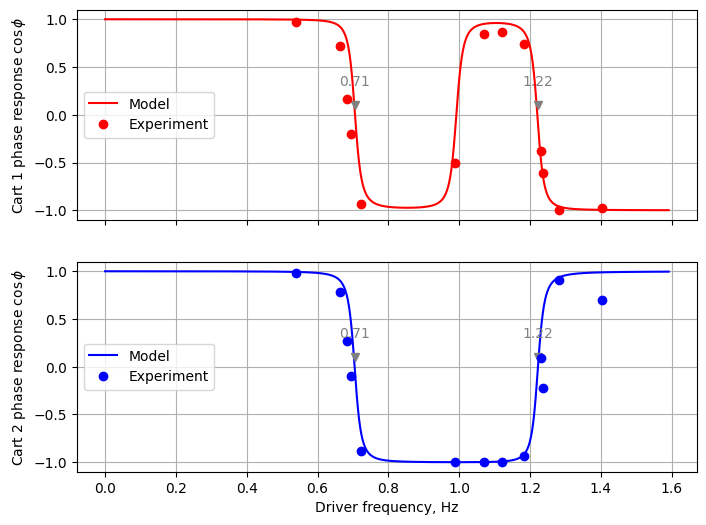

In [33]:
names = [300, 360, 370, 380, 390, 510, 550, 570, 600,  618, 620, 640, 700]
fw = np.array([])
cos1 = np.array([])
cos2 = np.array([])

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 6), sharex=True)

colors = ['red', 'blue']
# Model plot
for i in [0,1]:
  model_cos = np.cos(np.angle(c))
  axes[i].plot(omegas/pi2, model_cos[i],  c=colors[i], label=f'Model')
  # mark natural freqs
  for nat in omega_theor/pi2:
    axes[i].plot(nat, 0.1, color='gray', marker="v")
    axes[i].annotate(f'{nat:.2f}', xy=(nat, 0.3),  color='gray', ha='center')

# Experiment points
for name in names:
  url = f'https://raw.githubusercontent.com/evgeny-kolonsky/Lab3_Coupled_Oscillator/main/2611/2/r2_{name}.txt'
  t, xdriver, x1, x2 = get_signal(url, show=False)
  # get driver frequency
  fw = np.append(fw, get_frequency(t, xdriver)[0])
  cos1 = np.append(cos1, get_cosine(xdriver, x1))
  cos2 = np.append(cos2, get_cosine(xdriver, x2))

axes[0].plot(fw, cos1, 'o', c=colors[0], label='Experiment')
axes[1].plot(fw, cos2, 'o', c=colors[1], label='Experiment')

# common settings
for i in [0,1]:
  axes[i].grid()
  axes[i].legend(loc='center left')
  axes[i].set_ylabel(f'Cart {i+1} phase response $\cos\phi$')
  #plt.ylim(0, np.max(c1)*1.1)
  #plt.yticks(np.arange(0, np.max(c1)*1.1))
  #plt.xlim(0, np.max(omegas/pi2))

plt.xlabel(r'Driver frequency, Hz')
#plt.xlim(0, 1.4)
plt.show();